# DQN

## Q-learning

$$
L_{TD} = \left( r + \gamma \max_{a'} Q[s', a'] \right) - Q[s,a] \\
Q[s,a] = Q[s,a] + \alpha L_{TD}
$$

## DQN

Q-table => Q-function with NN approximation

$$
L_{TD} = \left( r+\gamma \max_{a'} Q_\theta(s', a') \right) - Q_\theta(s,a) \\
L_{NN} = (L_{TD})^2
$$

- Replay memory (NIPS 2013)
- Freeze target network (Nature 2015)

# Issue

- target.detach() + L1 loss (abs) 를 사용하면 학습이 안 됨.

이유가 뭘까?

In [1]:
%matplotlib inline
import collections
import random
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'0.4.1.post2'

In [3]:
env = gym.make('CartPole-v0')

In [4]:
gym.__version__

'0.10.9'

In [5]:
SEED = 4
env.seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
env.observation_space

Box(4,)

In [7]:
env.action_space

Discrete(2)

In [8]:
class DQN(nn.Module):
    def __init__(self, n_obs, n_action, n_hidden=64):
        """ 2-hidden layer NN
        n_obs: # of observations
        n_action: # of actions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_obs, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_action)
        )
    
    def forward(self, x):
        return self.net(x)
    
    def act(self, x):
        return torch.argmax(self.forward(x)).item()

In [9]:
class ReplayMemory(collections.deque):
    def __init__(self, maxlen, device):
        super().__init__(maxlen=maxlen)
        self.device = device
    
    def sample(self, size):
        # state, action, reward, next_state, done
        sarsd_list = zip(*random.sample(self, size))
        return list(map(lambda x: torch.FloatTensor(x).to(device), sarsd_list))

In [10]:
state = env.reset()

In [11]:
state

array([ 0.02543978,  0.02580473, -0.00815877,  0.01237681])

In [12]:
def calc_td_error(memory, batch_size, gamma):
    # calc td error
    state, action, reward, next_state, done = memory.sample(batch_size)
#     print(state.size(), action.size(), reward.size(), next_state.size(), done.size())
    cur_Q = net(state).gather(dim=1, index=action.long().unsqueeze(1)).squeeze()
    next_Q = net(next_state).max(dim=1)[0] 
    # stop gradient to next_Q
    next_Q = next_Q.detach()
    # if done, next_q should be 0.
    next_Q = next_Q * (1-done)
    
    target = reward + gamma * next_Q
    pred = cur_Q

    td_error = target - pred
    
    return td_error

In [13]:
n_episode = 100
eps = 1.0
eps_min = 0.001
eps_decay = 0.997
batch_size = 32
gamma = 0.99 # discount factor
memory_size = 1000
device = torch.device("cuda")

memory = ReplayMemory(maxlen=memory_size, device=device)
net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

losses = []
rewards = []

for episode in range(n_episode):
    state = env.reset()
    done = False
    t = 0
    total_reward = 0
    while not done:
        t += 1
        if np.random.rand() <= eps:
            # random move
            action = env.action_space.sample()
        else:
            action = net.act(torch.FloatTensor(state).to(device))
        
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        memory.append((state, action, reward, next_state, done))
        
        # training
        if len(memory) >= batch_size:
            td_error = calc_td_error(memory, batch_size, gamma)
            # 왜 abs() 는 워킹하지 않을까?
#             loss = td_error.abs().mean()
            loss = torch.mean(td_error **2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        
        # prepare next iteration
        state = next_state
        eps = max(eps * eps_decay, eps_min)
    
    print("[EP {:4d}] Done in Timestep {}. Reward = {}, Current epsilon = {}".format(episode, t+1, total_reward, eps))
    rewards.append(total_reward)

[EP    0] Done in Timestep 16. Reward = 15.0, Current epsilon = 0.9559328248389055
[EP    1] Done in Timestep 13. Reward = 12.0, Current epsilon = 0.9220814271464737
[EP    2] Done in Timestep 15. Reward = 14.0, Current epsilon = 0.884100203995605
[EP    3] Done in Timestep 16. Reward = 15.0, Current epsilon = 0.8451404054461714
[EP    4] Done in Timestep 10. Reward = 9.0, Current epsilon = 0.8225935318117279
[EP    5] Done in Timestep 47. Reward = 46.0, Current epsilon = 0.7164115395363275
[EP    6] Done in Timestep 15. Reward = 14.0, Current epsilon = 0.6869020127744744
[EP    7] Done in Timestep 18. Reward = 17.0, Current epsilon = 0.6526982980599124
[EP    8] Done in Timestep 17. Reward = 16.0, Current epsilon = 0.6220639206484622
[EP    9] Done in Timestep 11. Reward = 10.0, Current epsilon = 0.6036519339730777
[EP   10] Done in Timestep 12. Reward = 11.0, Current epsilon = 0.5840275546579663
[EP   11] Done in Timestep 15. Reward = 14.0, Current epsilon = 0.5599710231774805
[EP   

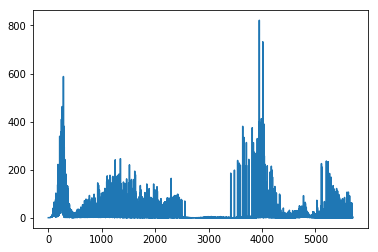

In [14]:
plt.plot(losses)

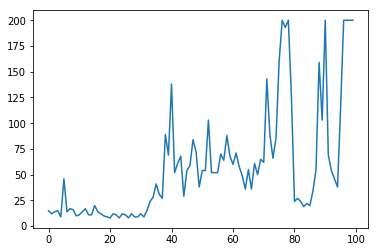

In [15]:
plt.plot(rewards)